In [1]:
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [59]:
def generate_graph(data_dict, xaxis_measure, yaxis_measure, save=False, legend_outside=False):
    try:
        col1 = f[xaxis_measure]
        col2 = f[yaxis_measure]
    except:
        print("Skipping measures: " + xaxis_measure + " " + yaxis_measure)
        return
    else:

        if len(col1) == 0:
            print("Skipping graph containing no data:" + title)
            return

        if col1[0] == 'None':
            print("Skipping missing column %s" % xaxis_measure)
            return

        if col2[0] == 'None':
            print("Skipping missing column %s" % yaxis_measure)
            return


#         scale = scale_color_brewer(type='qual', palette=1)
#         d3.schemeCategory20
#         ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a", "#d62728", "#ff9896",
#          "#9467bd", "#c5b0d5", "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7",
#          "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"]
#         colors = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a",
#                   "#d62728", "#ff9896", "#9467bd", "#c5b0d5", "#8c564b", "#c49c94",
#                   "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7", "#bcbd22", "#dbdb8d",
#                   "#17becf", "#9edae5"]

        shapes = ['o', 'D', '*', 's', '^']
        # with plt.style.context('seaborn'):  # optional
        fig, plots = plt.subplots(ncols=len(data_dict), figsize=(20, 6))
        legends = []
        for plot, (title, data) in zip(plots, data_dict.items()):
            for i, (name, (group, do_fill)) in enumerate(data.items()):
                if do_fill:
                    plot.plot(group[xaxis_measure], group[yaxis_measure], shapes[i], label=name,
                          #c=colors[i]
                         )
                else:
                    plot.plot(group[xaxis_measure], group[yaxis_measure], shapes[i], label=name,
                          #c=colors[i]
                          mfc='none'
                         )
            plot.set_xlabel(xaxis_measure)
            plot.set_ylabel(yaxis_measure)
            plot.set_title(title)
            plot.grid()
            if legend_outside:
                legends.append(plot.legend(loc='upper left', bbox_to_anchor=(1, 1)))
            else:
                plot.legend()
        if save:
            save_path = Path("results") / Path("analysis") / Path(title)
            save_path.mkdir(parents=True, exist_ok=True)
            figure_path = str(save_path / Path(f"{xaxis_measure}-{yaxis_measure}.png"))
            if legend_outside:
                fig.savefig(figure_path, bbox_extra_artists=legends, bbox_inches='tight')
            else:
                fig.savefig(figure_path)
            # print(xaxis_measure, yaxis_measure)

In [39]:
def parse(filename):
    data = pd.read_csv(filename)
    return {name: group for name, group in data.groupby('algorithm')}

In [58]:
def parse_all(filenames_and_titles, condition=None, mapping=None):
    data = {}
    no_cond = (condition is None)
    no_map = (mapping is None)
    for filename, title in filenames_and_titles:
        rows = parse(filename)
        new_rows = {}
        for algo_name, values in rows.items():
            if no_cond or condition(algo_name):
                new_algo_name, do_fill = (algo_name, True) if no_map else mapping(algo_name)
                new_rows[new_algo_name] = (values, do_fill)
        data[title] = new_rows
    return data

In [41]:
def plot_all(filenames_and_titles, xaxis, yaxis, condition=None, mapping=None):
    data = parse_all(filenames_and_titles, condition, mapping)
    generate_graph(data, xaxis, yaxis)

In [48]:
def start_filter(startwith):
    def filt(x):
        return x.startswith(startwith)
    return filt

In [37]:
graphs = [('DIbinary', 'accuracy')]
filenames_and_titles = [
    ('../../results/parity_tar/adult_race_numerical-binsensitive.csv', 'Adult (race)'),
    ('../../results/parity_tar/adult_sex_numerical-binsensitive.csv', 'Adult (sex)'),
]

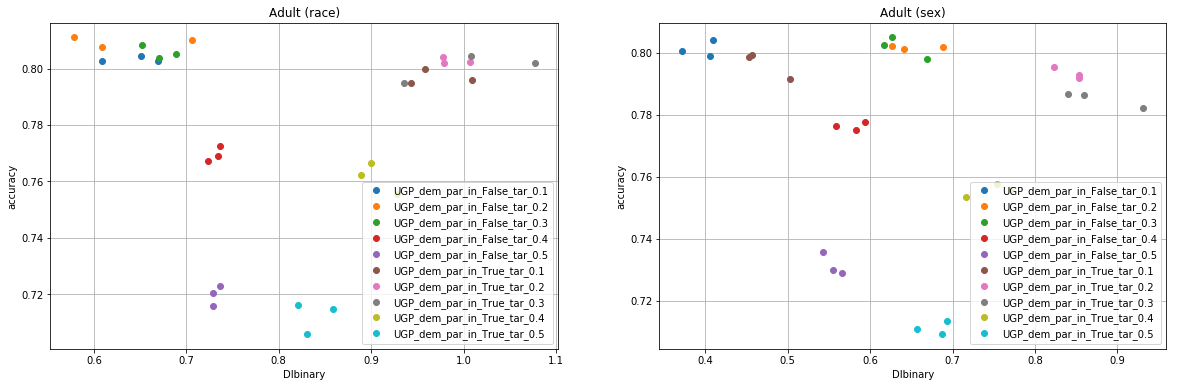

In [38]:
for xaxis, yaxis in graphs:
    plot_all(filenames_and_titles, xaxis, yaxis)
plt.show()

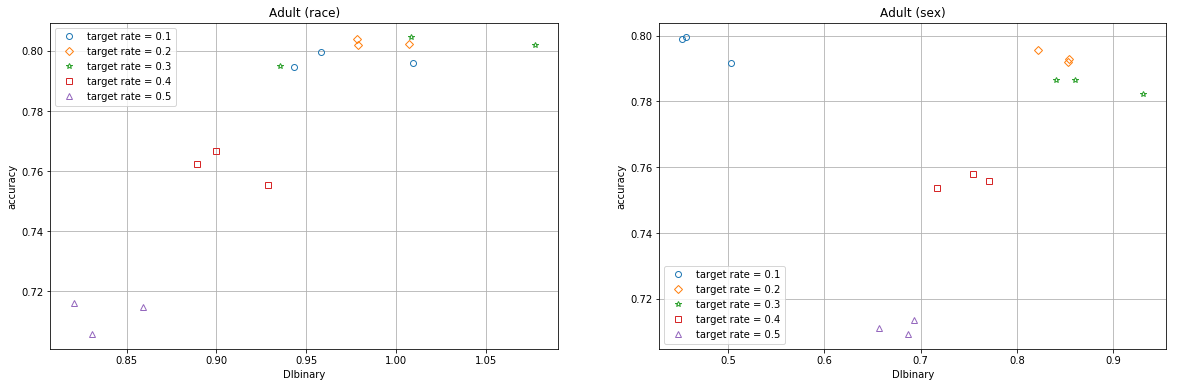

In [61]:
def label_change(label):
    num = label.split('_')[-1]
    return f"target rate = {num}", False

data = parse_all(filenames_and_titles, start_filter('UGP_dem_par_in_True'), label_change)
generate_graph(data, 'DIbinary', 'accuracy')